In [15]:
import numpy as np
import sqlite3

from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

from utils.get_or_create_combined_database import get_or_create_combined_database
from utils.create_sequences_in_batches import calculate_sequences_in_batches
from utils.compare_models import compare_models
from utils.get_data import clear_cache, fetch_data_batches
from utils.recreate_cleaned_data import recreate_cleaned_data

from utils.create_sequences_in_batches import create_sequences_from_database_rows
from utils.plot_prediction_on_plot import plot_prediction_on_plot
from utils.create_prediction_animation import create_prediction_animation
from matplotlib import pyplot as plt

from constants import DB_columns

import os
from dotenv import load_dotenv
load_dotenv(verbose=True, override=True)

RECREATE_CLEANED_DATA = False
TRAINING = True

zoom_range = ((75, 14350), (75, 14350))
normalized_zoom_range = ((0, 1), (0, 1))

# Data

In [16]:
database_folder = os.getenv("DATABASE_FOLDER")

database_file = get_or_create_combined_database(database_folder)

table_name = "champs_cleaned"

Found 2 database files in the folder specified by DATABASE_FOLDER
Found combined database /u/23/tarpill1/unix/Documents/combined2.db


In [17]:
if RECREATE_CLEANED_DATA:
    recreate_cleaned_data(database_file, table_name)

In [18]:
# Check values from the new table

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

page_size = 5

rows = cursor.execute(
    f"SELECT * FROM {table_name} LIMIT {page_size}").fetchall()

conn.close()

rows

[('Mordekaiser',
  604.0,
  612.0,
  5.5419455,
  645.0,
  100,
  2841236401,
  '2841236401_100_Mordekaiser',
  0.040266666666666666,
  0.0408,
  0.03078858611111111,
  0.0645),
 ('Viego',
  786.0,
  436.0,
  5.5419455,
  630.0,
  100,
  2841236401,
  '2841236401_100_Viego',
  0.0524,
  0.029066666666666668,
  0.03078858611111111,
  0.063),
 ('Riven',
  364.0,
  136.0,
  5.5419455,
  745.0,
  100,
  2841236401,
  '2841236401_100_Riven',
  0.024266666666666666,
  0.009066666666666667,
  0.03078858611111111,
  0.0745),
 ('Ezreal',
  132.0,
  402.0,
  5.5419455,
  600.0,
  100,
  2841236401,
  '2841236401_100_Ezreal',
  0.0088,
  0.0268,
  0.03078858611111111,
  0.06),
 ('Leblanc',
  298.0,
  676.0,
  5.5419455,
  598.0,
  100,
  2841236401,
  '2841236401_100_Leblanc',
  0.019866666666666668,
  0.045066666666666665,
  0.03078858611111111,
  0.0598)]

# Models

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim


def train_model(model, X_train, y_train, epochs=50, batch_size=64, learning_rate=0.001, cutoff_loss=None):
    device = model.device
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        pbar = tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            output = model(X_batch)
            # Only use the first two feature dimensions for loss calculation
            loss = criterion(output[:, :2], y_batch[:, :2])
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'Loss': loss.item()})
        current_loss = loss.item()
        if cutoff_loss is not None and current_loss < cutoff_loss:
            print(
                f'Loss is below cutoff value of {cutoff_loss}. Stopping training.')
            break
        pbar.close()


# Function to predict with the PyTorch model


def predict_model(model, X, batch_size=64, no_progress=True):
    device = model.device
    model.to(device)
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    dataset = torch.utils.data.TensorDataset(X_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    predictions = []
    pbar = tqdm(loader, desc='Predicting') if not no_progress else loader
    with torch.no_grad():
        for X_batch, in pbar:
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
    return np.vstack(predictions)


class TrajectoryPredictor(nn.Module):
    def __init__(self, input_shape, output_shape, lstm_units=128, dropout_rate=0.2, device='cpu', parameters=None):
        super(TrajectoryPredictor, self).__init__()
        self.lstm1 = nn.LSTM(input_shape[-1], lstm_units, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, output_shape)
        self.device = device
        if parameters is not None:
            self.epochs = parameters['epochs']
            self.batch_size = parameters['batch_size']
            self.learning_rate = parameters['learning_rate']
        else:
            self.epochs = 10
            self.batch_size = 640
            self.learning_rate = 0.001

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])  # taking the output of the last time step
        return x

    def fit(self, X, y, cutoff_loss=None):
        train_model(self, X, y, self.epochs,
                    self.batch_size, self.learning_rate, cutoff_loss)

    def predict(self, X):
        return predict_model(self, X, self.batch_size)

## Training

In [20]:
# Training Parameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device')

data_features = [DB_columns.NORMALIZED_POS_X.value,
                 DB_columns.NORMALIZED_POS_Z.value,
                 DB_columns.NORMALIZED_TIME.value,
                 DB_columns.NORMALIZED_HP.value]

total_keys_to_fetch = 1000

H_values = [200]
T_values = [100]

Using cuda device


In [21]:
linear_regression_features = [
    DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]

model_getters = {
    'linear_regression': lambda H, T: (LinearRegression(), linear_regression_features, (-1, H*len(linear_regression_features))),
    'lstm': lambda H, T: (TrajectoryPredictor(
        input_shape=(H, len(data_features)),
        output_shape=2,
        device=device,
        parameters={'epochs': 10, 'batch_size': 256,
                    'learning_rate': 0.001},
    ), data_features, (-1, H, len(data_features)))
}

In [22]:
if TRAINING:
    trained_models, mse_results, absolute_errors = compare_models(
        database_file, table_name, H_values, T_values, model_getters, data_features=data_features, total_keys_to_fetch=total_keys_to_fetch, batch_size=total_keys_to_fetch, train=True)

    print(mse_results)

Model loop:   0%|          | 0/2 [00:00<?, ?it/s]

Using in-memory cache for counts
Fetched 1000 keys for offset: 0, limit: 1000


Fitting model linear_regression with features ['normalized_pos_x', 'normalized_pos_z']


Model loop:  50%|█████     | 1/2 [00:05<00:05,  5.11s/it]


Fitting model lstm with features ['normalized_pos_x', 'normalized_pos_z', 'normalized_time', 'normalized_hp']


Epoch 1/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/988 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/988 [00:00<?, ?it/s]

Model loop: 100%|██████████| 2/2 [02:12<00:00, 77.30s/it]

Model loop: 100%|██████████| 2/2 [02:12<00:00, 66.47s/it]

defaultdict(<class 'list'>, {(200, 100, 'linear_regression'): [0.013277046], (200, 100, 'lstm'): [0.008846731]})


In [23]:
# Print rmse results
if TRAINING:
    for model_name, mse in mse_results.items():
        print(f"{model_name}: {mse}")

(200, 100, 'linear_regression'): [0.013277046]
(200, 100, 'lstm'): [0.008846731]


In [24]:
# Save models
folder = 'models'
if TRAINING:
    for model_name, model in trained_models.items():
        file_name = f'{"_".join([str(part) for part in model_name])}.pt'
        file_name = os.path.join(folder, file_name)
        torch.save(model, file_name)

In [25]:
# Load models
if not TRAINING:
    trained_models = {}
    model_names = model_getters.keys()
    model_file_names = [ f'{H}_{T}_{model_name}.pt' for H in H_values for T in T_values for model_name in model_names]
    for file_name in model_file_names:
        model_name_parts = file_name.split('.')[0].split('_')
        model_name = (int(model_name_parts[0]), int(model_name_parts[1]), '_'.join(model_name_parts[2:]))
        trained_models[model_name] = torch.load(os.path.join(folder, file_name))
trained_models

{(200, 100, 'linear_regression'): LinearRegression(),
 (200,
  100,
  'lstm'): TrajectoryPredictor(
   (lstm1): LSTM(4, 128, batch_first=True)
   (dropout1): Dropout(p=0.2, inplace=False)
   (lstm2): LSTM(128, 128, batch_first=True)
   (dropout2): Dropout(p=0.2, inplace=False)
   (fc): Linear(in_features=128, out_features=2, bias=True)
 )}

Using in-memory cache for counts
Fetched 30 keys for offset: 0, limit: 30
Predicting with model linear_regression
Best sequence index: [3037 8742 3038 3059 3060]
Worst sequence index: [6629 6631 2422 6632 6630]
(5, 400)
(5, 2)
(5, 2)


Predicting with model lstm
Best sequence index: [5524 5688 5689 5525 5523]
Worst sequence index: [7283 7279 7280 7282 7281]
(5, 400)
(5, 2)
(5, 2)


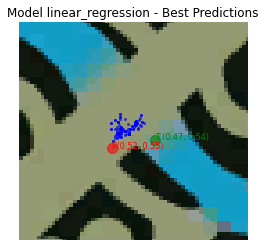

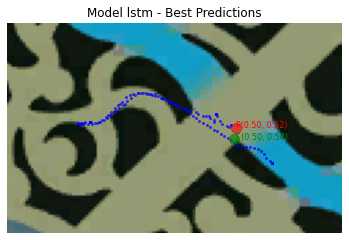

In [29]:
# Make a prediction with each model and compare it to the actual values

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

data = fetch_data_batches(cursor, table_name, "1=1", 0, 30, data_features)

max_H = max(H_values)
max_T = max(T_values)

for (H, T, model_name), model in trained_models.items():
    input_shape = model_getters[model_name](H, T)[2]
    features = model_getters[model_name](H, T)[1]
    print(f"Predicting with model {model_name}")
    sequences = create_sequences_from_database_rows(data, H, T, max_H, max_T)
    X, y = sequences
    X_test_features = X[:, :, [
        data_features.index(feature) for feature in features]]
    X_test_features = X_test_features.reshape(
        X_test_features.shape[0], *input_shape)
    # Run the prediction on all the sequences
    y_pred = [ model.predict(X_test_features[i]) for i in range(X_test_features.shape[0]) ]
    y_pred = np.array(y_pred, dtype=np.float32)
    # Visualize the best and worst predictions
    mses = np.mean((y - y_pred) ** 2, axis=(1, 2))
    absolute_errors = np.mean(np.abs(y - y_pred), axis=(1, 2))

    number_of_best_sequences = 5

    best_sequence_indices = np.argpartition(absolute_errors, number_of_best_sequences)[:number_of_best_sequences]
    worst_sequence_indices = np.argpartition(absolute_errors, -number_of_best_sequences)[-number_of_best_sequences:]
    print(f"Best sequence index: {best_sequence_indices}")
    print(f"Worst sequence index: {worst_sequence_indices}")

    plotting_features = [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]
    plotting_input_shape = [H*len(plotting_features)]
    X_test_plotting_features = X[:, :, [
        data_features.index(feature) for feature in plotting_features]]
    X_test_plotting_features = X_test_plotting_features.reshape(
        X_test_plotting_features.shape[0], *plotting_input_shape)

    best_sequences = X_test_plotting_features[best_sequence_indices]
    worst_sequence = X_test_plotting_features[worst_sequence_indices]

 

    best_predictions = y_pred[best_sequence_indices].reshape(-1, y_pred.shape[-1])[: , :2]
    worst_predictions = y_pred[worst_sequence_indices].reshape(-1, y_pred.shape[-1])[ : , :2]

    best_truths = y[best_sequence_indices].reshape(-1, len(y[0]))[: , :2]
    worst_truths = y[worst_sequence_indices].reshape(-1, len(y[0]))[ : , :2]

    print(best_sequences.shape)
    print(best_predictions.shape)
    print(best_truths.shape)

    # # Plot the best and worst predictions
    # plotting_options = {
    #     "padding": 0.1,
    #     "truthPointsSize": 10,
    #     "predictionPointsSize": 10,
    #     "title": f"Model {model_name} - Best Prediction"
    # }
    # plot_prediction_on_plot(plt, best_sequence, [best_truth[:2]], [
    #                         best_prediction[:2]], "assets/2x_2dlevelminimap.png", normalized_zoom_range, plotting_options)
    
    # plotting_options = {
    #     "padding": 0.1,
    #     "truthPointsSize": 10,
    #     "predictionPointsSize": 10,
    #     "title": f"Model {model_name} - Worst Prediction"
    # }
    # plot_prediction_on_plot(plt, worst_sequence, [worst_truth[:2]], [
    #                         worst_prediction[:2]], "assets/2x_2dlevelminimap.png", normalized_zoom_range, plotting_options)
    
    # Animate the best and worst predictions

    plotting_options = {
        "padding": 0.1,
        "truthPointsSize": 10,
        "predictionPointsSize": 10,
        "title": f"Model {model_name} - Best Predictions"
    }

    ani = create_prediction_animation(best_sequences, best_truths, best_predictions, "assets/2x_2dlevelminimap.png", normalized_zoom_range, plotting_options)
    display(ani)

Predicting with model linear_regression
Best sequence index: [5509 5522 5510 5507 5508]
Worst sequence index: [6629 6631 2422 6632 6630]


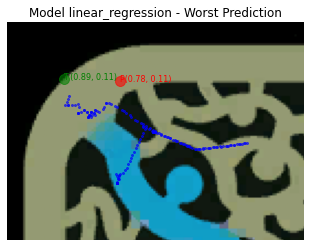

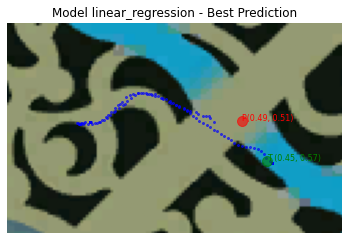

Predicting with model lstm
Best sequence index: [1125 1124 1123 1122 1121]
Worst sequence index: [7283 7279 7280 7282 7281]


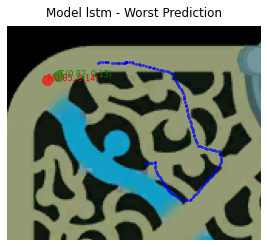

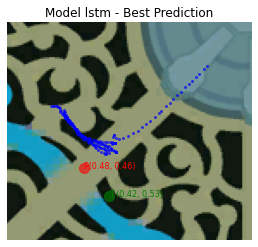

<Figure size 432x288 with 0 Axes>

In [27]:
# Output the best and worst predictions

for (H, T, model_name), model in trained_models.items():
    input_shape = model_getters[model_name](H, T)[2]
    features = model_getters[model_name](H, T)[1]
    print(f"Predicting with model {model_name}")
    sequences = create_sequences_from_database_rows(data, H, T, max_H, max_T)
    X, y = sequences
    X_test_features = X[:, :, [
        data_features.index(feature) for feature in features]]
    X_test_features = X_test_features.reshape(
        X_test_features.shape[0], *input_shape)
    # Run the prediction on all the sequences
    y_pred = [ model.predict(X_test_features[i]) for i in range(X_test_features.shape[0]) ]
    y_pred = np.array(y_pred, dtype=np.float32)
    # Visualize the best and worst predictions
    mses = np.mean((y - y_pred) ** 2, axis=(1, 2))

    number_of_best_sequences = 5

    best_sequence_indices = np.argpartition(mses, number_of_best_sequences)[:number_of_best_sequences]
    worst_sequence_indices = np.argpartition(mses, -number_of_best_sequences)[-number_of_best_sequences:]
    print(f"Best sequence index: {best_sequence_indices}")
    print(f"Worst sequence index: {worst_sequence_indices}")

    plotting_features = [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]
    plotting_input_shape = [H*len(plotting_features)]
    X_test_plotting_features = X[:, :, [
        data_features.index(feature) for feature in plotting_features]]
    X_test_plotting_features = X_test_plotting_features.reshape(
        X_test_plotting_features.shape[0], *plotting_input_shape)

    best_sequences = X_test_plotting_features[best_sequence_indices]
    worst_sequence = X_test_plotting_features[worst_sequence_indices]

 

    best_predictions = y_pred[best_sequence_indices].reshape(-1, y_pred.shape[-1])[: , :2]
    worst_predictions = y_pred[worst_sequence_indices].reshape(-1, y_pred.shape[-1])[ : , :2]

    best_truths = y[best_sequence_indices].reshape(-1, len(y[0]))[: , :2]
    worst_truths = y[worst_sequence_indices].reshape(-1, len(y[0]))[ : , :2]

    # Plot the worst prediction 
    plotting_options = {
        "padding": 0.1,
        "truthPointsSize": 10,
        "predictionPointsSize": 10,
        "title": f"Model {model_name} - Worst Prediction"
    }

    plot_prediction_on_plot(plt, worst_sequence[0:1], worst_truths[0:1], worst_predictions[0:1], "assets/2x_2dlevelminimap.png", normalized_zoom_range, plotting_options)

    # Save the worst prediction
    
    folder = f"output/{model_name}"
    os.makedirs(folder, exist_ok=True)
    file_name = f"{folder}/worst_prediction.png"
    plt.savefig(file_name)

    # Plot the best prediction

    plotting_options = {
        "padding": 0.1,
        "truthPointsSize": 10,
        "predictionPointsSize": 10,
        "title": f"Model {model_name} - Best Prediction"
    }

    plot_prediction_on_plot(plt, best_sequences[0:1], best_truths[0:1], best_predictions[0:1], "assets/2x_2dlevelminimap.png", normalized_zoom_range, plotting_options)

    # Save the best prediction

    folder = f"output/{model_name}"
    os.makedirs(folder, exist_ok=True)
    file_name = f"{folder}/best_prediction.png"
    plt.savefig(file_name)


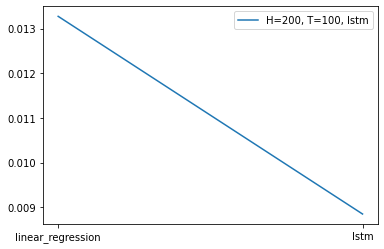

In [28]:
# Plot the mse results
from matplotlib import pyplot as plt

for H in H_values:
    for T in T_values:
        model_names = model_getters.keys()
        mse_values = [mse_results[(H, T, model_name)] for model_name in model_names]
        plt.plot(model_names, mse_values, label=f'H={H}, T={T}, {model_name}')
plt.legend()